In [5]:
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from DataProcessing import *
from FeatureEngineering import *

#### Instantiate data object *data*  and assign train and test sets

In [6]:
ordinalcodes = {'degree':{'NONE':0,'HIGH_SCHOOL':1,'BACHELORS':2,'MASTERS':3,
                          'DOCTORAL':4},
                'jobType':{'JANITOR':0,'JUNIOR':1,'SENIOR':2,'MANAGER':3,
                           'VICE_PRESIDENT':4,'CFO':5,'CTO':6,'CEO':7},
               }

data = Data(fname_Xtrain='train_features.csv',fname_ytrain='train_salaries.csv',
         fname_Xtest='test_features.csv',
         columns_cat=['companyId','degree','industry','jobType','major'],
         columns_num=['milesFromMetropolis','yearsExperience'],
         ylabel='salary',joinId='jobId',ordinal_dict=ordinalcodes)

# assign vectorized pre-feature-engineered train data 
vec_train_df = data._preprocessData(data.train_df,clean=True,encode=True,nominal_cols=['companyId','industry','major'])

# drop zero-valued response rows and encode categorical features to numeric for train and test sets 
train_df = data._preprocessData(data.train_df,clean=True,encode=True,nominal_cols=['companyId','industry','major'])
test_df = data._preprocessData(data.Xtest_df,clean=False,encode=True,nominal_cols=['companyId','industry','major'])

# drop response,id columns from train and id column from train and test sets
Xtrain_df = train_df.drop([data.ylabel,data.id],axis=1)
ytrain_df = train_df[data.ylabel]
Xtest_df = test_df.drop(data.id,axis=1)

display(Xtrain_df.head())
display(Xtest_df.head())


,milesFromMetropolis,yearsExperience,companyId,industry,major,degree,jobType
0,83,10,31,3,6,3,5
1,73,3,11,6,7,1,7
2,38,10,48,3,8,4,4
3,17,8,32,0,2,4,3
4,16,8,60,2,8,2,4


,milesFromMetropolis,yearsExperience,companyId,industry,major,degree,jobType
0,73,22,27,3,7,1,3
1,47,20,5,0,7,0,1
2,9,17,2,3,0,3,6
3,96,14,14,4,7,1,3
4,44,10,30,4,0,4,1


#### Instantiate feature engineering object *featureEng* and generate grouped categorical and numeric feature response statistics as new features   

In [7]:
featureEng = FeatureEng(data_object=data) 

Xtrain_df = featureEng._compute_new_features(vec_train_df,Xtrain_df,cat_columns=data.columns_cat,num_columns=data.columns_num,qcuts=4)
Xtest_df = featureEng._compute_new_features(vec_train_df,Xtest_df,cat_columns=data.columns_cat,num_columns=data.columns_num,qcuts=4)

In [8]:
class ModelManager:
    '''
    manage estimator predictions and loss, feature importances 
    '''
    def __init__(self,data_object=None,model_list=None,loss_dict=None,folds=None,best_estimator=None,yhat_test=None):
        self.data = data_object
        self.estimator_list = model_list
        self.loss_dict = loss_dict
        self.folds = folds
        self.best_estimator = best_estimator
        self.yhat_test = yhat_test

    def _add_estimator(self,estimator=None):
        '''
        add linear estimator to self.model_list
        '''
        self.estimator_list.append(estimator)
    
    
    def _cross_validate_estimator(self,estimator=None,Xtrain=None,ytrain=None):
        '''
        train, cross validate linear estimator and assign loss metrics to self.loss_dict
        and obtain best estimator 
        '''
        # compute k-fold cross-validated neg_mse
        scores_array = cross_val_score(estimator,
                                      Xtrain,ytrain,
                                      scoring='neg_mean_squared_error',
                                      cv=self.folds)
        #mse 
        cv_mse_mean = np.nanmean(-1.0*scores_array)
        cv_mse_std = np.std(scores_array)
        # rmse
        scores_array_rmse = np.sqrt(-1.0*scores_array)
        cv_rmse_mean = np.nanmean(-1.0*scores_array_rmse)
        cv_rmse_std = np.std(scores_array_rmse)
        # assign average cv train MSE value to corresponding loss_dict key
        self.loss_dict[estimator] = cv_mse_mean
        
    def _select_best_estimator(self):
        '''
        assign best_estimator as estimator with minimal MSE value in self.loss_dict
        '''
        best_estimator = min(self.loss_dict,key=self.loss_dict.get)
        return best_estimator

    
    def _fit_best_estimator(self,Xtrain,ytrain):
        '''
        fit best estimator from _cross_validate_estimator 
        '''
        return self.best_estimator.fit(Xtrain,ytrain)
        

    def _predict_best_estimator(self,Xtest):
        '''
        generate best estimator prediction self.yhat_test from _cross_validate_estimator
        '''
        return self.best_estimator.predict(Xtest)

    
    def _compute_feature_importances(self,Xtrain=None,figsz=(12,6),xrotate=45):
        '''
        return feature_importance attribute from estimator, when available
        '''
        print('Feature Importance Summary:')
        best_estimator = self.best_estimator.steps[1][1]
        if hasattr(best_estimator,'feature_importances_'):
            f_importances = best_estimator.feature_importances_
            importances_df = pd.DataFrame({'feature':Xtrain.columns,'importance':f_importances})
            importances_df.set_index('feature',inplace=True,drop=True)
            importances_df.sort_values(by='importance',ascending=False,inplace=True)
            display(importances_df)
            importances_df.plot(kind='bar',figsize=figsz,rot=xrotate)
        else:
            print('self.best_estmimator does not have attribute feature_importances_')
        
    def _summarize_estimators(self):
        print('Linear Estimator Cross-Validated Loss Summary:')
        for est in self.loss_dict:
            print('\n{}'.format(est.steps[1][1]))
            print('\t MSE:',self.loss_dict[est])
            
        # show best estimator
        self.best_estimator = self._select_best_estimator()
        print('\n')
        print('-'*70)
        print('Best estimator:\n{}'.format(self.best_estimator.steps[1][1]))
        print('-'*70)


#### Assign ModelManager global parameters

In [9]:
loss_container = {}
estimatorList = []

#### Instantiate ModeManager and pre-tuned linear estimators
- *let LinearRegression* be a baseline model


In [10]:
model_mgr = ModelManager(data_object=data,model_list=estimatorList,loss_dict=loss_container,folds=5,
                        best_estimator=None,yhat_test=None)   

reg_pipe = make_pipeline(SimpleImputer(strategy='median'),
                         LinearRegression()
                        )

rf_pipe = make_pipeline(SimpleImputer(strategy='median'),
                        RandomForestRegressor(
                                             n_estimators=70,
                                             max_depth=11,
                                             min_samples_split=40,
                                             min_samples_leaf=25,
                                             min_weight_fraction_leaf=0,
                                             max_features=.875,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0,
                                             bootstrap=True
                                             )
                       )

gb_pipe = make_pipeline(SimpleImputer(strategy='median'),
                        GradientBoostingRegressor(
                                                  learning_rate=.1875,
                                                  n_estimators=250,
                                                  subsample=1,
                                                  min_samples_split=3,
                                                  min_samples_leaf=500,
                                                  min_weight_fraction_leaf=0,
                                                  max_depth=3,
                                                  min_impurity_decrease=0,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  criterion='friedman_mse'
                                                 )
                       )

#### Determine cross-validated estimators, summarize results, display best estimator results 

Linear Estimator Cross-Validated Loss Summary:

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1875, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0, min_impurity_split=None,
             min_samples_leaf=500, min_samples_split=3,
             min_weight_fraction_leaf=0, n_estimators=250,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
	 MSE: 313.004559011

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
	 MSE: 342.913857272

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features=0.875, max_leaf_nodes=None,
           min_impurity_decrease=0, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=40,
           min_weight_fraction_leaf=0, n_es

,importance
feature,
cat_group_mean,0.677002
numeric_quantile_std,0.080250
numeric_quantile_min,0.070284
numeric_quantile_mean,0.046077
numeric_quantile_max,0.024691
cat_group_min,0.020841
yearsExperience,0.017398
numeric_quantile_median,0.016741
cat_group_std,0.015962


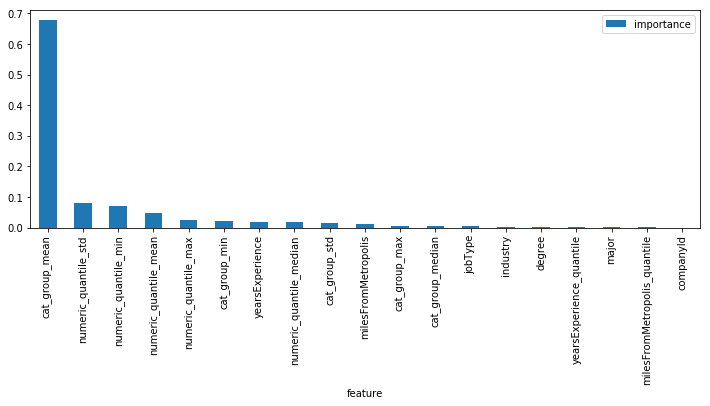

In [11]:
model_mgr._add_estimator(reg_pipe)
model_mgr._add_estimator(rf_pipe)
model_mgr._add_estimator(gb_pipe)

for estimator in model_mgr.estimator_list:
    model_mgr._cross_validate_estimator(estimator=estimator,Xtrain=Xtrain_df[:],ytrain=ytrain_df[:])
    
model_mgr._summarize_estimators()
model_mgr.best_estimator = model_mgr._select_best_estimator()
model_mgr._fit_best_estimator(Xtrain=Xtrain_df[:],ytrain=ytrain_df[:])
model_mgr._predict_best_estimator(Xtest_df[:])
model_mgr._compute_feature_importances(Xtrain=Xtrain_df,figsz=(12,4),xrotate=90)    